# Deep Learning on tabular/ structured data

Based on: https://www.kaggle.com/abhikjha/fastai-pytorch-hooks-random-forest?source=post_page-----1748aa2b2f8c----------------------

In [112]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [113]:
import pandas as pd
import numpy as np

import fastai
from fastai import *
from fastai.vision import *
from fastai.tabular import *

from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback, SaveModelCallback

#from utils import *
import sys

from scipy.special import erfinv
import matplotlib.pyplot as plt

import torch
#from torch.utils.data import *
from torch.optim import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm

np.random.seed(42)

In [114]:
# helper functions
def to_gauss(x): 
    return np.sqrt(2)*erfinv(x)

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()       # list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)  
        normal = to_gauss(uniform)                                # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col                                # column receives its corresponding rank
    return data

In [115]:
# data
df_train = pd.read_csv("../input/train.csv")
df_test  = pd.read_csv("../input/test.csv")

FileNotFoundError: [Errno 2] File b'../input/train.csv' does not exist: b'../input/train.csv'

In [116]:
# add column names
wilderness = [f'Wilderness_Area{i}' for i in range(1,5)]  # 4 one-hot-encoded wilderness types
soiltypes = [f'Soil_Type{i:02}' for i in range(1,41)]  # 40 one-hot-encoded soil types
colnames = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
            'Horizontal_Distance_To_Fire_Points'] + wilderness + soiltypes + ['Cover_Type']


In [117]:
# read and transform one-hot cols into dense form
df = pd.read_csv('covtype.data', names=colnames, header=None, sep=',')
df['Soil'] = df.filter(like='Soil_Type').idxmax(axis=1).astype('category').cat.codes
df['Wilderness'] = df.filter(like='Wilderness_Area').idxmax(axis=1).astype('category').cat.codes
df = df[df.columns.drop(list(df.filter(regex='Soil_|Wilderness_')))]
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil,Wilderness
0,2596,51,3,258,0,510,221,232,148,6279,5,28,0
1,2590,56,2,212,-6,390,220,235,151,6225,5,28,0
2,2804,139,9,268,65,3180,234,238,135,6121,2,11,0
3,2785,155,18,242,118,3090,238,238,122,6211,2,29,0
4,2595,45,2,153,-1,391,220,234,150,6172,5,28,0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Cover_Type                            581012 non-null int64
Soil                                  581012 non-null int8
Wilderness                            581012 non-null int8
dtypes: int64(11), int8(2)
memory usage: 49.9 MB


In [119]:
procs=[FillMissing, Categorify]

cat_vars = ['Soil', 'Wilderness']

cont_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
             'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'] 

dep_var = 'Cover_Type'

In [120]:
df = normalize(df, exclude=cat_vars + [dep_var])

In [121]:
data = (TabularList.from_df(df, path='.', cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols=dep_var)   #, label_cls=FloatList
                .databunch(bs=1024))

In [122]:
data.show_batch()

Soil,Wilderness,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,target
27,2,-0.8021,0.8015,2.2297,1.5166,2.3098,-0.9529,-2.4743,-0.6858,2.4766,0.1539,2
32,2,1.3103,0.3414,0.9273,-0.4213,-2.0340,0.4408,-0.0170,1.6086,0.3613,-1.5980,1
32,2,0.4887,-0.4532,0.7511,0.7497,0.7547,0.5894,1.1973,-1.1350,-1.4825,-1.0419,1
31,2,0.1151,0.2460,-0.3677,0.5439,-0.8658,-0.4307,0.4856,1.0699,0.1185,-0.3088,2
4,3,-1.6769,-0.1674,1.2844,-0.7248,0.2491,-0.7242,2.2589,-1.2310,-1.9286,-0.3795,6


In [129]:
learn = tabular_learner(data, layers=[1000,500], metrics=accuracy, model_dir=".",
                        ps=[0.1, 0.1], emb_drop=0.04, emb_szs={'Soil': (40+1)//2, 'Wilderness': (4+1)//2})

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.20E-02


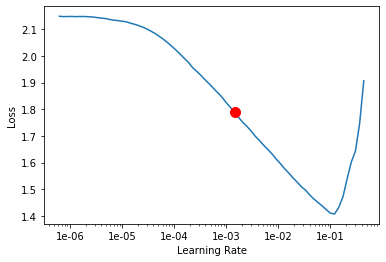

In [130]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [131]:
lr = 1e-2
learn.fit_one_cycle(5, max_lr=lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.474624,0.462624,0.796880,00:14
1,0.402043,0.387153,0.837886,00:14
2,0.354702,0.333234,0.862593,00:15
3,0.274208,0.239663,0.903160,00:15
4,0.222800,0.196718,0.920939,00:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.45E-04


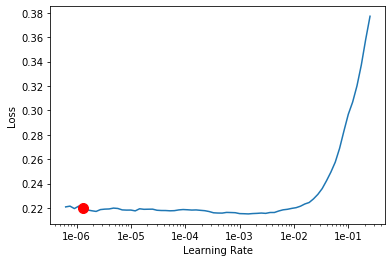

In [132]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [133]:
lr = 1e-4
learn.fit_one_cycle(5, lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.215796,0.193835,0.921697,00:15
1,0.211818,0.190223,0.923211,00:14
2,0.209936,0.186618,0.925380,00:14
3,0.207508,0.185445,0.925870,00:15
4,0.204220,0.185189,0.925845,00:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.92E-05


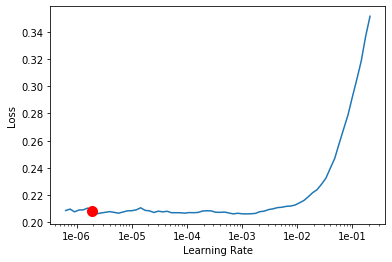

In [134]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [135]:
lr=1e-6
learn.fit_one_cycle(5, max_lr=lr, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.206887,0.184786,0.925853,00:15
1,0.207020,0.184661,0.926077,00:14
2,0.208236,0.184711,0.925957,00:15
3,0.206066,0.185137,0.925793,00:14
4,0.205172,0.184461,0.926094,00:15


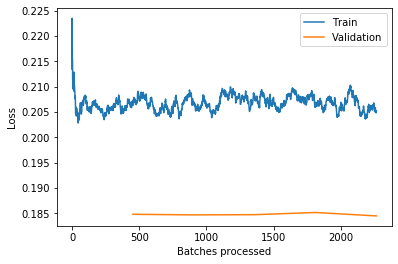

In [136]:
learn.save('1')
learn.recorder.plot_losses()

In [137]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [138]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(41, 20)
    (1): Embedding(5, 2)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=500, out_features=7, bias=True)
  )
)

In [139]:
sf = SaveFeatures(learn.model.layers[4])

In [140]:
_ = learn.get_preds(data.train_ds)

In [141]:
label = [x for x in (list(data.train_ds.y.items))]

In [142]:
len(label)

464810

In [143]:
df_new = pd.DataFrame({'label': label})
df_new.head()

,label
0,4
1,1
2,4
3,1
4,4


In [144]:
df_new['emb'] = np.array(sf.features).tolist()


In [145]:
df_new.head()

,label,emb
0,4,"[-1.6962991952896118, 2.5190658569335938, -6.0..."
1,1,"[-0.34193384647369385, -0.08448757976293564, -..."
2,4,"[-1.7670300006866455, 2.395880937576294, -5.83..."
3,1,"[-3.1183133125305176, 1.8079334497451782, -7.6..."
4,4,"[-1.4538503885269165, 1.783381700515747, -4.31..."


In [146]:
d2 = pd.DataFrame(df_new.emb.values.tolist(), index = df_new.index).rename(columns = lambda x: f'emb{x+1}')

In [147]:
df_new_2 = df_new.join(d2)

In [148]:
df_new_2.shape

(464810, 502)

## Embeddings for Validation

In [149]:
sf = SaveFeatures(learn.model.layers[4])

In [150]:
_ = learn.get_preds(DatasetType.Valid)

In [151]:
label = [x for x in (list(data.valid_ds.y.items))]

In [152]:
df_new_valid = pd.DataFrame({'label': label})

In [153]:
df_new_valid['emb'] = np.array(sf.features).tolist()

In [154]:
d2 = pd.DataFrame(df_new_valid.emb.values.tolist(), index = df_new_valid.index).rename(columns = lambda x: f'emb{x+1}')

In [155]:
df_new_valid_2 = df_new_valid.join(d2)

In [158]:
df_new_valid_2.drop(['emb'], axis=1, inplace=True)
df_new_2.drop(['emb'], axis=1, inplace=True)

In [159]:
corr_matrix = df_new_2.corr()
corr_matrix["label"].sort_values(ascending = False)

label     1.000000
emb123    0.325975
emb314    0.304764
emb141    0.289648
emb436    0.281750
            ...   
emb127   -0.349580
emb185   -0.351112
emb174   -0.358178
emb62    -0.361068
emb131   -0.376091
Name: label, Length: 501, dtype: float64

In [160]:
X = df_new_2
y = df_new_2.label.copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [161]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((371848, 501), (371848,), (92962, 501), (92962,))

In [162]:
y_train = X_train.label
X_train = X_train.drop("label", axis =1)

y_test = X_test.label
X_test = X_test.drop("label", axis =1)

In [163]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((371848, 500), (371848,), (92962, 500), (92962,))

In [164]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names].values

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_train.columns)),
    ('Std_Scaler', StandardScaler())
])

X_train_transformed = num_pipeline.fit_transform(X_train)
X_test_transformed = num_pipeline.fit_transform(X_test)

In [166]:
X_train_transformed.shape, X_test_transformed.shape

((371848, 500), (92962, 500))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

start = time.time()

rf_clf = RandomForestClassifier(bootstrap=True,
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=185, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

rf_clf.fit(X_train_transformed, y_train)

end = time.time()

print("run_time:", (end-start)/(60*60))

In [ ]:
a

## Prediction

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score

import time

start = time.time()

score_rf = cross_val_score(rf_clf, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error', verbose=0)
print(score_rf.mean())

end = time.time()

print("run_time:", (end-start)/(60*60))

In [ ]:
y_pred_test_rf = rf_clf.predict(X_test_transformed)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test_rf)

In [100]:
X = df_new_valid_2
y = df_new_valid_2.label.copy()

In [101]:
X_val = X.drop("label", axis =1)
y_val = y

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_val.columns)),
    ('Std_Scaler', StandardScaler())
])


X_val_transformed = num_pipeline.fit_transform(X_val)

In [103]:
y_pred_test_rf_val = rf_clf.predict(X_val_transformed)

NameError: name 'rf_clf' is not defined

In [105]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred_test_rf_val)

NameError: name 'y_pred_test_rf_val' is not defined